In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from tqdm import tqdm
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device="cuda")
queries = [
    "Artiklen undersøger kunstig intelligens og machine learning.",
    "Teksten handler om AI-politik, regulering og etik.",
    "Dette dokument beskriver AI-teknologi, GPT og automatisering.",
    "Artiklen diskuterer brugen af robotter og generativ AI."
]

keywords_query = ["AI", "kunstig intelligens", "maskinlæring", "dyb læring", "neural netværk", "automatisering",
                  "robotik", "dataanalyse", "algoritme", "intelligente systemer", "GPT", "OPENAI", "LLM", "chatbot",
                    "sprogmodel", "generativ AI", "AI-assistent", "AI-drevet", "computer vision", "naturlig sprogbehandling",
                    "AI-platform", "AI-teknologi", "AI-forskning", "AI-innovation", "AI-applikationer", "AI-løsninger",
                    "AI-udvikling", "AI-sikkerhed", "AI-etik", "AI-regulering", "AI-politik", "AI-strategi", "AI-investering",
                    "AI-startup", "AI-industrien", "AI-marked", "AI-trends", "AI-fremtid", "robotter", "automatiserede systemer",
                    "intelligente maskiner", "AI-integration", "AI-implementering", "AI-optimering", "AI-overvågning",]


emb = np.load("results/01_embeddings.npy")
df = pd.read_csv("results/00_raw_data.csv")
ai_vec = model.encode(queries, normalize_embeddings=True)
query_vec = np.mean(ai_vec, axis=0)
negative_queries = [
    "Artiklen handler IKKE om kunstig intelligens, AI teknologi eller automatisering.",
    "Denne tekst drejer sig om almindelige nyheder, kultur, sport eller lokale begivenheder – ikke AI.",
    "Dokumentet indeholder ingen information om machine learning, GPT eller algoritmer.",
    "Teksten beskriver sociale, politiske eller menneskelige historier uden relation til AI eller IT teknologi."
]


neg_emb = model.encode(negative_queries, normalize_embeddings=True)
true_score =  util.cos_sim(emb, ai_vec) -  util.cos_sim(emb, neg_emb)
ai_final_score = true_score.mean(dim=1)
keyword_scores = []
# key words search score
for index, row in df.iterrows():
    text = row['plain_text'].lower()
    # check if keywords exist in text
    keyword_score = sum(1 for kw in keywords_query if kw.lower() in text)
    keyword_scores.append(keyword_score)

keyword_scores = np.array(keyword_scores)
df['keyword_score'] = keyword_scores


df["ai_score"] = ai_final_score
ai_score_simple = util.cos_sim(emb, query_vec)
df["ai_score_simple"] = ai_score_simple.mean(dim=1)
df["is_ai"] = df["ai_score"] > 0
df.to_csv("results/02_ai_scores_v2.csv", index=False)

print("AI-related articles:", df["is_ai"].sum())



E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AI-related articles: 14608


In [88]:
df['keyword_score'] = keyword_scores

In [2]:
# ai score vs keyword score correlation
correlation = np.corrcoef(df["ai_score"], df["keyword_score"])[0, 1]
print("Correlation between AI score and Keyword score:", correlation)

# ai score simple vs keyword score correlation
correlation_simple = np.corrcoef(df["ai_score_simple"], df["keyword_score"])[0, 1]
print("Correlation between Simple AI score and Keyword score:", correlation_simple)

Correlation between AI score and Keyword score: 0.14747121053968482
Correlation between Simple AI score and Keyword score: -0.05090577749917281


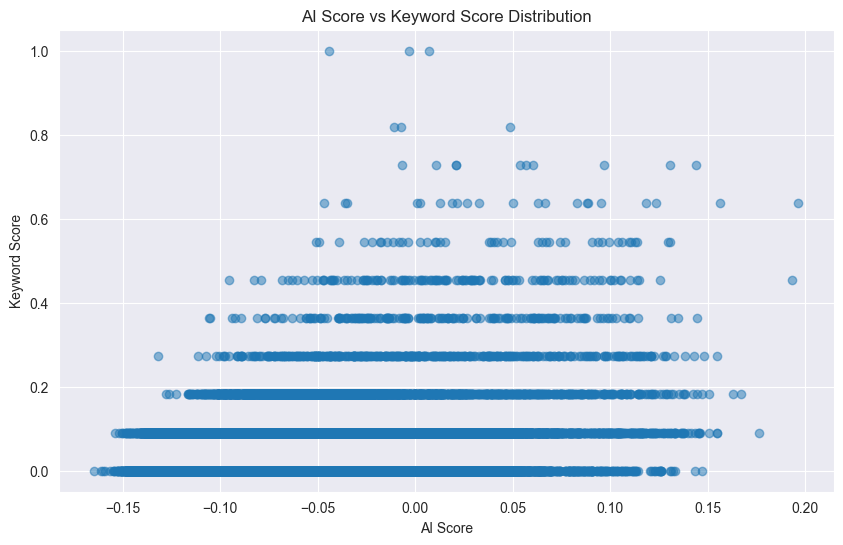

In [3]:
# plot ai score vs keyword score distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df["ai_score"], df["keyword_score"], alpha=0.5)
plt.title("AI Score vs Keyword Score Distribution")
plt.xlabel("AI Score")
plt.ylabel("Keyword Score")
plt.savefig("figures/ai_score_vs_keyword_score.png")
plt.show()

In [6]:

import ollama
import pandas as pd

results = []

def check_ai_via_ollama(text: str) -> bool:

    prompt = (
        "You are a strict AI detector.\n"
        "Question: Is the following article mainly about artificial intelligence (AI), "
        "machine learning, GPT, or automation?\n"
        "Answer strictly with only one word: 'ja' for yes or 'nej' for no.\n\n"
        f"Article:\n{text}\n\n"
        "Answer:"
    )

    response = ollama.chat(
        model="gemma3:latest",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    content = response["message"]["content"].strip().lower()
    if content.startswith("ja"):
        return True
    if content.startswith("nej"):
        return False
    return False


for index, row in sample_df.iterrows():
    text = (row["plain_text"] or "")[:2000]  # 保险地处理 None，限制长度
    is_ai = check_ai_via_ollama(text)

    results.append({
        "index": index,
        "ai_score": row["ai_score"],
        "ai_score_simple": row["ai_score_simple"],
        "keyword_score": row["keyword_score"],
        "is_ai_ollama": is_ai,
        "total_length": len(text),
    })

results_df = pd.DataFrame(results)


ollama_label = results_df["is_ai_ollama"]

results_df["is_ai_sbert"] = results_df["ai_score"] > 0
results_df["is_ai_simple"] = results_df["ai_score_simple"] > 0


accuracy_sbert = (results_df["is_ai_sbert"] == ollama_label).mean()
print(f"AI Detection Accuracy (SBERT score > 0 vs Ollama): {accuracy_sbert * 100:.2f}%")


accuracy_simple = (results_df["is_ai_simple"] == ollama_label).mean()
print(f"AI Detection Accuracy (simple score > 0 vs Ollama): {accuracy_simple * 100:.2f}%")

AI Detection Accuracy (SBERT score > 0 vs Ollama): 78.00%
AI Detection Accuracy (simple score > 0 vs Ollama): 28.00%


In [65]:
import pandas as pd
import numpy as np
import ollama

# 从最高 ai_score 的前 500 条里随机 100 条
sample_ai = (
    df.sort_values(by="ai_score", ascending=False)
      .iloc[:500]
      .sample(n=100, random_state=42)
      .copy()
)
sample_ai["score_source"] = "ai_score"        # 标记来源
sample_ai["score_bucket"] = "top500"          # 想分桶就简单写个 tag

# 从最高 ai_score_simple 的前 500 条里随机 100 条
sample_simple = (
    df.sort_values(by="ai_score_simple", ascending=False)
      .iloc[:500]
      .sample(n=100, random_state=43)         # 换个 random_state
      .copy()
)
sample_simple["score_source"] = "ai_score_simple"
sample_simple["score_bucket"] = "top500"

# 合并
sample_df = pd.concat([sample_ai, sample_simple], ignore_index=True)

print(f"Total samples for Ollama: {len(sample_df)}")  # 应该是 200
sample_df.to_csv("results/03_ai_sample_for_ollama_top500.csv", index=False)
print("Saved sample to results/03_ai_sample_for_ollama_top500.csv")



Total samples for Ollama: 200
Saved sample to results/03_ai_sample_for_ollama_top500.csv


In [69]:
results = []

def check_ai_via_ollama(text: str) -> bool:
    prompt = (
        "You are a strict AI detector.\n"
        "Question: Is the following article mainly about artificial intelligence (AI), "
        "machine learning, GPT, or automation?\n"
        "Answer strictly with only one word: 'ja' for yes and 'nej' for no.\n\n"
        f"Article:\n{text}\n\n"
        "Answer:"
    )

    response = ollama.chat(

        model="gemma3:latest",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    content = response["message"]["content"].strip().lower()
    if content.startswith("ja"):
        return True
    if content.startswith("nej"):
        return False
    # 不听话就当不是AI
    return False


# use tqdm for progress bar
from tqdm import tqdm

for index, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    text = (row["plain_text"] or "")[:2000]

    is_ai = check_ai_via_ollama(text)

    results.append({
        "orig_index": row.name,                  # 原始df的index
        "ai_score": row["ai_score"],
        "ai_score_simple": row["ai_score_simple"],
        "keyword_score": row["keyword_score"],
        "is_ai_ollama": is_ai,
        "total_length": len(text),
        "score_source": row["score_source"],
        "score_bucket": row["score_bucket"],
  # 属于哪个百分位区间
    })

results_df = pd.DataFrame(results)


100%|██████████| 200/200 [01:11<00:00,  2.78it/s]


In [62]:
print(results_df["ai_score"].describe())
print(results_df["ai_score_simple"].describe())

count    200.000000
mean       0.091292
std        0.035398
min       -0.015366
25%        0.073930
50%        0.094963
75%        0.114222
max        0.196637
Name: ai_score, dtype: float64
count    200.000000
mean       0.616449
std        0.068520
min        0.307999
25%        0.600975
50%        0.623733
75%        0.650718
max        0.779792
Name: ai_score_simple, dtype: float64


In [70]:
import numpy as np

# 1. 先生成两个方法自己的二值预测（阈值先用 > 0，之后你可以调）
results_df["pred_ai_score"] = results_df["ai_score"].fillna(0) > 0
results_df["pred_ai_score_simple"] = results_df["ai_score_simple"].fillna(0) > 0

# 2. 按来源分别创建 mask
mask_ai = results_df["score_source"] == "ai_score"
mask_simple = results_df["score_source"] == "ai_score_simple"

# 3. 对于 ai_score 抽出来的那 100 条，用 pred_ai_score 和 Ollama 比
acc_ai = (results_df.loc[mask_ai, "pred_ai_score"] ==
          results_df.loc[mask_ai, "is_ai_ollama"]).mean()

# 4. 对于 ai_score_simple 抽出来的那 100 条，用 pred_ai_score_simple 和 Ollama 比
acc_simple = (results_df.loc[mask_simple, "pred_ai_score_simple"] ==
              results_df.loc[mask_simple, "is_ai_ollama"]).mean()

print(f"Accuracy for top500-high ai_score (threshold > 0): {acc_ai * 100:.2f}%")
print(f"Accuracy for top500-high ai_score_simple (threshold > 0): {acc_simple * 100:.2f}%")



Accuracy for top500-high ai_score (threshold > 0): 55.00%
Accuracy for top500-high ai_score_simple (threshold > 0): 57.00%


In [54]:
results_df

,orig_index,ai_score,ai_score_simple,keyword_score,is_ai_ollama,total_length,score_source,score_bucket,pred_ai_score,pred_ai_score_simple,pred_for_source,correct
0,0,-0.063194,0.358796,0.000000,False,2000,ai_score,60-80%,False,True,False,True
1,1,-0.061136,0.339283,0.000000,False,2000,ai_score,60-80%,False,True,False,True
2,2,-0.056712,0.412224,0.000000,False,2000,ai_score,60-80%,False,True,False,True
3,3,-0.062693,0.320080,0.000000,False,2000,ai_score,60-80%,False,True,False,True
4,4,-0.064514,0.241540,0.000000,False,719,ai_score,60-80%,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,-0.068983,0.218439,0.090909,False,1366,ai_score_simple,0-20%,False,True,True,False
1996,1996,-0.112902,0.234717,0.000000,False,1333,ai_score_simple,0-20%,False,True,True,False
1997,1997,-0.058967,0.290007,0.000000,False,751,ai_score_simple,0-20%,False,True,True,False
1998,1998,-0.098407,0.284052,0.000000,False,1092,ai_score_simple,0-20%,False,True,True,False


In [58]:
# find those ai ollama true in original df
ai_indices = results_df[results_df["is_ai_ollama"] == True]["orig_index"].unique()
# output that plain text to ternimal
for idx in ai_indices:

    print(sample_df.loc[idx, "plain_text"])
    print("-" * 80)


Får Grønland et etisk råd?  Tilbage i 2017 blev det besluttet, at man ville etablere et etisk råd i Grønland, men ifølge Mimi Karlsen (IA) blev oprettelsen sat i bero i 2018.  Hvad blev der egentlig af oprettelsen af et etisk råd i Grønland?  Det undrer IA´s inatsisartutmedlem Mariia Simonsen sig over. Derfor stillede hun den 31. maj et paragraf 37-spørgsmål vedrørende oprettelsen af netop et etisk råd.  Tilbage i 2017 vedtog et enigt Inatsisartut at etablere et etisk råd, men det fremgår ingen steder, om dette råd er blevet nedsat.  Den 17. juni 2022 – cirka to uger efter, at Mariia Simonsen stillede sit spørgsmål – modtog hun svar på sin henvendelse.  - Naalakkersuisut kan oplyse, at lovforslaget om oprettelsen af et Etisk Råd blev sat i bero i 2018.  Vil uddybe spørgsmål  Sådan lyder svaret fra Mimi Karlsen, Naalakkersuisoq for Børn, Unge, Familier og Sundhed (IA).  - Det er et meget kort svar, men man får svar, som man spørger, siger Mariia Simonsen til Sermitsiaq.AG og tilføjer:  

In [72]:
# -*- coding: utf-8 -*-
"""
Full evaluation script:
- Sample data in several different ways
- Call Ollama to label whether each article is AI-related
- Compare ai_score vs ai_score_simple
- Collect all metrics into a single report table (DataFrame + CSV)
"""

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import ollama
from tqdm import tqdm

# ------------------------------------------------------------
# 0. CONFIG
# ------------------------------------------------------------

MODEL_NAME = "gemma3:latest"    # Ollama model name
MAX_TEXT_LEN = 2000             # 每篇文章截断长度（字符数）
GLOBAL_RANDOM_N = 300           # 全局随机抽样数量
TOP_K = 500                     # topK 高分池
TOP_SAMPLE_N = 100              # 从 topK 中随机抽多少
STRAT_N_BINS = 5                # 分位桶数（0-20,20-40,...）
STRAT_N_PER_BIN = 60            # 每个分位桶抽多少
DISAGREE_N_PER_ZONE = 80        # 每种“分歧类型”抽多少
DISAGREE_HIGH_T = 0.08          # “高分”阈值（ai 高 / simple 高）
DISAGREE_LOW_T = 0.0            # “低分”阈值（ai 低 / simple 低）
THRESHOLDS = [0.0, 0.02, 0.05, 0.08, 0.10]  # 用来扫不同阈值的列表

# ------------------------------------------------------------
# 1. 报表收集器：所有指标都往这里塞
# ------------------------------------------------------------

report_rows = []

def add_row(subset, method, bucket, metric, value, n_samples):
    """
    subset: 哪类样本（global_random / top500_high / stratified_quintile / disagree 等）
    method: 哪个打分方法（ai_score / ai_score_simple）
    bucket: 子分组，比如 'all' 或 '0-20%' / '80-100%' / 'ai_high_simple_low'
    metric: 指标名称，比如 'auc', 'accuracy_thr>0.05'
    value: 指标值（float）
    n_samples: 该组样本数
    """
    report_rows.append({
        "subset": subset,
        "method": method,
        "bucket": bucket,
        "metric": metric,
        "value": float(value),
        "n_samples": int(n_samples),
    })

def build_report_df():
    return pd.DataFrame(report_rows)

# ------------------------------------------------------------
# 2. Ollama 调用：给一段文本返回 True/False（是否 AI 相关）
# ------------------------------------------------------------

def check_ai_via_ollama(text: str) -> bool:
    """
    用 Ollama 问一句：这篇文章是不是关于 AI/ML/GPT/自动化？
    返回 True(ja) / False(nej)
    """
    prompt = (
        "You are a strict AI detector.\n"
        "Question: Is the following article mainly about artificial intelligence (AI), "
        "machine learning, GPT, or automation?\n"
        "Answer strictly with only one word: 'ja' for yes and 'nej' for no.\n\n"
        f"Article:\n{text}\n\n"
        "Answer:"
    )

    response = ollama.chat(
        model=MODEL_NAME,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    content = response["message"]["content"].strip().lower()
    if content.startswith("ja"):
        return True
    if content.startswith("nej"):
        return False
    # 如果模型不听话，保守当作 False
    return False

def label_with_ollama(sample_df: pd.DataFrame, subset_name: str) -> pd.DataFrame:
    """
    对 sample_df 的每一行用 Ollama 打标签。
    保留打分、来源、桶信息，并新增 is_ai_ollama 和 subset。
    """
    rows = []
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc=f"Ollama labeling [{subset_name}]"):
        text = (row.get("plain_text", "") or "")[:MAX_TEXT_LEN]
        is_ai = check_ai_via_ollama(text)

        rows.append({
            "subset": subset_name,
            "ai_score": row["ai_score"],
            "ai_score_simple": row["ai_score_simple"],
            "keyword_score": row.get("keyword_score", np.nan),
            "is_ai_ollama": is_ai,
            "score_source": row.get("score_source", "both"),
            "score_bucket": row.get("score_bucket", "all"),
            "zone": row.get("zone", "all"),
        })

    return pd.DataFrame(rows)

# ------------------------------------------------------------
# 3. 各种抽样方法
#    注意：这里假设 df 已经在全局变量里存在
#    df 至少需要列：plain_text, ai_score, ai_score_simple
# ------------------------------------------------------------

def sample_global_random(df: pd.DataFrame, n: int, random_state: int = 123) -> pd.DataFrame:
    """全局随机抽样 n 条"""
    return df.sample(n=n, random_state=random_state).copy()

def sample_top_k(df: pd.DataFrame, score_col: str, top_k: int, sample_n: int, random_state: int = 42) -> pd.DataFrame:
    """
    从 score_col 得分最高的 top_k 条里，随机抽 sample_n 条。
    """
    top = df.sort_values(score_col, ascending=False).iloc[:top_k].copy()
    sample_n = min(sample_n, len(top))
    sampled = top.sample(n=sample_n, random_state=random_state).copy()
    sampled["score_source"] = score_col
    sampled["score_bucket"] = f"top{top_k}"
    return sampled

def stratified_by_score_ranges(df: pd.DataFrame, score_col: str,
                               n_bins: int = 5, n_per_bin: int = 60,
                               random_state: int = 42) -> pd.DataFrame:
    """
    按 score_col 把数据切成 n_bins 个分位区间（0-20,20-40,...），
    每个分位区间随机抽 n_per_bin 条。
    """
    df = df.copy()
    df["orig_index"] = df.index

    labels = [f"{int(100/n_bins*i)}-{int(100/n_bins*(i+1))}%" for i in range(n_bins)]
    bucket_col = "score_bucket"

    df[bucket_col] = pd.qcut(
        df[score_col],
        q=n_bins,
        labels=labels,
        duplicates="drop"
    )

    df = df.dropna(subset=[bucket_col])
    samples = []
    rng = np.random.default_rng(random_state)

    for b in df[bucket_col].dropna().unique():
        sub = df[df[bucket_col] == b]
        size = min(n_per_bin, len(sub))
        if size <= 0:
            continue
        seed = int(rng.integers(0, 1e9))
        s = sub.sample(n=size, random_state=seed).copy()
        s["score_source"] = score_col
        samples.append(s)

    sampled = pd.concat(samples, ignore_index=True)
    return sampled

def sample_disagree(df: pd.DataFrame,
                    high_t: float = 0.08,
                    low_t: float = 0.0,
                    n_per_zone: int = 80,
                    random_state: int = 999) -> pd.DataFrame:
    """
    抽样“分歧样本”：
    - zone='ai_high_simple_low': ai_score 高, ai_score_simple 低
    - zone='ai_low_simple_high': ai_score 低, ai_score_simple 高
    """
    df = df.copy()
    rng = np.random.default_rng(random_state)

    zone_a = df[(df["ai_score"] > high_t) & (df["ai_score_simple"] <= low_t)].copy()
    zone_b = df[(df["ai_score"] <= low_t) & (df["ai_score_simple"] > high_t)].copy()

    samples = []

    if len(zone_a) > 0:
        size_a = min(n_per_zone, len(zone_a))
        seed_a = int(rng.integers(0, 1e9))
        s_a = zone_a.sample(n=size_a, random_state=seed_a).copy()
        s_a["zone"] = "ai_high_simple_low"
        samples.append(s_a)

    if len(zone_b) > 0:
        size_b = min(n_per_zone, len(zone_b))
        seed_b = int(rng.integers(0, 1e9))
        s_b = zone_b.sample(n=size_b, random_state=seed_b).copy()
        s_b["zone"] = "ai_low_simple_high"
        samples.append(s_b)

    if not samples:
        return pd.DataFrame(columns=df.columns.tolist() + ["zone"])

    sampled = pd.concat(samples, ignore_index=True)
    sampled["score_source"] = "both"
    sampled["score_bucket"] = "disagree_zone"
    return sampled

# ------------------------------------------------------------
# 4. 主流程：抽样 + Ollama 打标签
#    注意：这里假设 df 已经定义好了
# ------------------------------------------------------------

# !!! 这里假设你之前已经加载好了 df !!!
# df = pd.read_csv("your_news_data.csv")  # 举例

all_results = []

# 4.1 全局随机样本
global_sample = sample_global_random(df, n=GLOBAL_RANDOM_N, random_state=123)
global_results_df = label_with_ollama(global_sample, subset_name="global_random")
all_results.append(global_results_df)

# 4.2 top500 高分样本（各方法自己 confident 的区域）
sample_ai_top = sample_top_k(df, "ai_score", TOP_K, TOP_SAMPLE_N, random_state=42)
sample_simple_top = sample_top_k(df, "ai_score_simple", TOP_K, TOP_SAMPLE_N, random_state=43)
top500_sample = pd.concat([sample_ai_top, sample_simple_top], ignore_index=True)
top500_results_df = label_with_ollama(top500_sample, subset_name="top500_high")
all_results.append(top500_results_df)

# 4.3 分位区间抽样（覆盖高/中/低不同区间）
sample_ai_strat = stratified_by_score_ranges(df, "ai_score",
                                             n_bins=STRAT_N_BINS,
                                             n_per_bin=STRAT_N_PER_BIN,
                                             random_state=1)
sample_simple_strat = stratified_by_score_ranges(df, "ai_score_simple",
                                                 n_bins=STRAT_N_BINS,
                                                 n_per_bin=STRAT_N_PER_BIN,
                                                 random_state=2)
strat_sample = pd.concat([sample_ai_strat, sample_simple_strat], ignore_index=True)
strat_results_df = label_with_ollama(strat_sample, subset_name="stratified_quintile")
all_results.append(strat_results_df)

# 4.4 分歧样本（一个高一个低）
disagree_sample = sample_disagree(df,
                                  high_t=DISAGREE_HIGH_T,
                                  low_t=DISAGREE_LOW_T,
                                  n_per_zone=DISAGREE_N_PER_ZONE,
                                  random_state=999)
if len(disagree_sample) > 0:
    disagree_results_df = label_with_ollama(disagree_sample, subset_name="disagree")
    all_results.append(disagree_results_df)

# 合并所有结果
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df["score_bucket"] = all_results_df["score_bucket"].fillna("all")
all_results_df["zone"] = all_results_df["zone"].fillna("all")

# ------------------------------------------------------------
# 5. 各种评估：写入统一报表
# ------------------------------------------------------------

# 5.1 全局随机样本：AUC + 多个阈值 accuracy
global_res = all_results_df[all_results_df["subset"] == "global_random"].copy()
y_g = global_res["is_ai_ollama"].astype(int)

for method, col in [("ai_score", "ai_score"), ("ai_score_simple", "ai_score_simple")]:
    # AUC
    auc_val = roc_auc_score(y_g, global_res[col])
    add_row("global_random", method, "all", "auc", auc_val, len(y_g))
    # 不同阈值 accuracy
    for thr in THRESHOLDS:
        pred = global_res[col] > thr
        acc_val = accuracy_score(y_g, pred)
        add_row("global_random", method, "all", f"accuracy_thr>{thr:.2f}", acc_val, len(y_g))

# 5.2 top500 高分样本：看各自高分区域的 accuracy（阈值先用 >0）
top_res = all_results_df[all_results_df["subset"] == "top500_high"].copy()

mask_ai_top = top_res["score_source"] == "ai_score"
mask_simple_top = top_res["score_source"] == "ai_score_simple"

y_ai_top = top_res.loc[mask_ai_top, "is_ai_ollama"].astype(int)
y_simple_top = top_res.loc[mask_simple_top, "is_ai_ollama"].astype(int)

pred_ai_top = top_res.loc[mask_ai_top, "ai_score"] > 0
pred_simple_top = top_res.loc[mask_simple_top, "ai_score_simple"] > 0

acc_ai_top = accuracy_score(y_ai_top, pred_ai_top)
acc_simple_top = accuracy_score(y_simple_top, pred_simple_top)

add_row("top500_high", "ai_score", "top500", "accuracy_thr>0.00", acc_ai_top, len(y_ai_top))
add_row("top500_high", "ai_score_simple", "top500", "accuracy_thr>0.00", acc_simple_top, len(y_simple_top))

# 5.3 分位区间抽样：看不同 score_bucket 的 accuracy（阈值 >0）
strat_res = all_results_df[all_results_df["subset"] == "stratified_quintile"].copy()

# 先构造两种方法的预测列
strat_res["pred_ai_score"] = strat_res["ai_score"] > 0
strat_res["pred_ai_score_simple"] = strat_res["ai_score_simple"] > 0

mask_ai_strat = strat_res["score_source"] == "ai_score"
mask_simple_strat = strat_res["score_source"] == "ai_score_simple"

# 对 ai_score 抽出来的样本
sub_ai = strat_res[mask_ai_strat].copy()
sub_ai["correct"] = sub_ai["pred_ai_score"] == sub_ai["is_ai_ollama"]

# 对 ai_score_simple 抽出来的样本
sub_simple = strat_res[mask_simple_strat].copy()
sub_simple["correct"] = sub_simple["pred_ai_score_simple"] == sub_simple["is_ai_ollama"]

# groupby 各自的 score_bucket
g_ai = (
    sub_ai.groupby("score_bucket")["correct"]
    .agg(["mean", "size"])
    .reset_index()
    .rename(columns={"mean": "accuracy", "size": "n_samples"})
)

g_simple = (
    sub_simple.groupby("score_bucket")["correct"]
    .agg(["mean", "size"])
    .reset_index()
    .rename(columns={"mean": "accuracy", "size": "n_samples"})
)

for _, r in g_ai.iterrows():
    add_row("stratified_quintile", "ai_score", r["score_bucket"], "accuracy_thr>0.00", r["accuracy"], r["n_samples"])

for _, r in g_simple.iterrows():
    add_row("stratified_quintile", "ai_score_simple", r["score_bucket"], "accuracy_thr>0.00", r["accuracy"], r["n_samples"])

# 5.4 分歧样本：谁在“打架区域”更靠谱
if "disagree" in all_results_df["subset"].unique():
    dis_res = all_results_df[all_results_df["subset"] == "disagree"].copy()
    y_d = dis_res["is_ai_ollama"].astype(int)

    # 两种方法用相同阈值 DISAGREE_HIGH_T
    pred_ai_d = dis_res["ai_score"] > DISAGREE_HIGH_T
    pred_simple_d = dis_res["ai_score_simple"] > DISAGREE_HIGH_T

    acc_ai_d = accuracy_score(y_d, pred_ai_d)
    acc_simple_d = accuracy_score(y_d, pred_simple_d)

    add_row("disagree_all", "ai_score", "all", f"accuracy_thr>{DISAGREE_HIGH_T:.2f}", acc_ai_d, len(y_d))
    add_row("disagree_all", "ai_score_simple", "all", f"accuracy_thr>{DISAGREE_HIGH_T:.2f}", acc_simple_d, len(y_d))

    # 再按 zone 分开看（ai_high_simple_low / ai_low_simple_high）
    for z, sub in dis_res.groupby("zone"):
        y_z = sub["is_ai_ollama"].astype(int)
        pred_ai_z = sub["ai_score"] > DISAGREE_HIGH_T
        pred_simple_z = sub["ai_score_simple"] > DISAGREE_HIGH_T

        acc_ai_z = accuracy_score(y_z, pred_ai_z)
        acc_simple_z = accuracy_score(y_z, pred_simple_z)

        add_row(f"disagree_{z}", "ai_score", "all", f"accuracy_thr>{DISAGREE_HIGH_T:.2f}", acc_ai_z, len(y_z))
        add_row(f"disagree_{z}", "ai_score_simple", "all", f"accuracy_thr>{DISAGREE_HIGH_T:.2f}", acc_simple_z, len(y_z))

# ------------------------------------------------------------
# 6. 生成总报表 & 导出
# ------------------------------------------------------------

report_df = build_report_df()
print(report_df)

report_df.to_csv("results/ai_score_comparison_report.csv", index=False)
print("Saved report to results/ai_score_comparison_report.csv")

# 可选：把 all_results_df 也存一下，方便以后复查每条样本
all_results_df.to_csv("results/ai_score_all_labeled_samples.csv", index=False)
print("Saved all labeled samples to results/ai_score_all_labeled_samples.csv")


Ollama labeling [disagree]: 100%|██████████| 80/80 [00:28<00:00,  2.76it/s]

                         subset           method   bucket             metric  \
0                 global_random         ai_score      all                auc   
1                 global_random         ai_score      all  accuracy_thr>0.00   
2                 global_random         ai_score      all  accuracy_thr>0.02   
3                 global_random         ai_score      all  accuracy_thr>0.05   
4                 global_random         ai_score      all  accuracy_thr>0.08   
5                 global_random         ai_score      all  accuracy_thr>0.10   
6                 global_random  ai_score_simple      all                auc   
7                 global_random  ai_score_simple      all  accuracy_thr>0.00   
8                 global_random  ai_score_simple      all  accuracy_thr>0.02   
9                 global_random  ai_score_simple      all  accuracy_thr>0.05   
10                global_random  ai_score_simple      all  accuracy_thr>0.08   
11                global_random  ai_scor


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [73]:
report_df

,subset,method,bucket,metric,value,n_samples
0,global_random,ai_score,all,auc,NaN,300
1,global_random,ai_score,all,accuracy_thr>0.00,0.996667,300
2,global_random,ai_score,all,accuracy_thr>0.02,1.000000,300
3,global_random,ai_score,all,accuracy_thr>0.05,1.000000,300
4,global_random,ai_score,all,accuracy_thr>0.08,1.000000,300
5,global_random,ai_score,all,accuracy_thr>0.10,1.000000,300
6,global_random,ai_score_simple,all,auc,NaN,300
7,global_random,ai_score_simple,all,accuracy_thr>0.00,0.000000,300
8,global_random,ai_score_simple,all,accuracy_thr>0.02,0.000000,300
9,global_random,ai_score_simple,all,accuracy_thr>0.05,0.000000,300


In [77]:
# min max normalize ai_score\ai score simple  in all_results_df
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
all_results_df["ai_score_norm"] = scaler1.fit_transform(all_results_df[["ai_score"]])
all_results_df["ai_score_simple_norm"] = scaler2.fit_transform(all_results_df[["ai_score_simple"]])






In [91]:
# adding original df's keyword score to all_results_df

all_results_df = all_results_df.merge(
    df[["ai_score", "ai_score_simple", "keyword_score"]],
    on=["ai_score", "ai_score_simple"],
    how="left"
)

In [92]:
pp = all_results_df[all_results_df["is_ai_ollama"] == True]
print(all_results_df[['ai_score_norm', 'ai_score_simple_norm','keyword_score']].mean())

ai_score_norm           0.267981
ai_score_simple_norm    0.401457
keyword_score           0.413425
dtype: float64
